idea: The dataset may contain wrong labels. A solution is detect anomalies in the dataset using Gaussian Mixture, and then inspect the anomaly data points

In [340]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, average_precision_score, accuracy_score

In [341]:
import warnings
warnings.filterwarnings("ignore")

In [342]:
from glob import glob
glob('./*')

['./Predict_bad_loan.ipynb',
 './Loan_Dataset_3.csv',
 './Loan_Dataset.csv',
 './Predict_bad_loan_cont_(Unsupervised_&_Supervised_approach).ipynb',
 './Loan_Dataset_2.csv',
 './Predict_bad_loan_cont_Anomaly_Detection.ipynb',
 './Predict_bad_loan_cont_(Dimensionality_Reduction_approach).ipynb',
 './variable_descriptions']

In [343]:
df_ori = pd.read_csv('Loan_Dataset_2.csv')

In [344]:
df_ori.columns

Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'annual_income_log', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_36 months', 'term_60 months', 'last_delinq_none_0',
       'last_delinq_none_1'],
      dtype='object')

In [345]:
df = df_ori.drop(columns =['annual_income_log'])
df.columns

Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_36 months',
       'term_60 months', 'last_delinq_none_0', 'last_delinq_none_1'],
      dtype='object')

In [346]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

gm = GaussianMixture(n_components=1, n_init=20, random_state=123)
gm.fit(df)

GaussianMixture(n_init=20, random_state=123)

In [347]:
gm.converged_, gm.n_iter_, gm.weights_

(True, 2, array([1.]))

In [396]:
densities = gm.score_samples(df)
density_threshold = np.percentile(densities, 40) #assume 10% of data has incorrect label
anomalies = df[densities < density_threshold]
normal = df[densities >= density_threshold]

In [397]:
norm_ind = normal.index

In [398]:
anomalies.bad_loan.mean(), anomalies.shape[0]

(0.3021230266739249, 7348)

In [399]:
X = df_ori.drop(columns=['id', 'annual_income','bad_loan','grade_A',
                     'home_ownership_MORTGAGE','purpose_car','term_36 months',
                     'last_delinq_none_0'])

X = X.iloc[norm_ind,:]

y = df_ori['bad_loan'].astype(int)

y = y[norm_ind]

In [400]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [401]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [402]:
def get_metrics(target_test, target_score):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    print(f'AUC is {pr_auc:.2f}')
    return precision, recall, pr_auc

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

In [403]:
param_grid = [{'C': [0.1, 1, 10, 100, 1000]}]

lg_clf = LogisticRegression(class_weight='balanced',
                            random_state = 123
                           )
     
grid_search = GridSearchCV(lg_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)
               
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 0.1}

In [404]:
lg_clf = grid_search.best_estimator_
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)
y_score = lg_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1174,738
Actual Positive,78,215


In [405]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.26


In [406]:
param_grid = [
    {'n_estimators': [95, 96, 97, 98],
     'max_depth': [1,2, 3, 4],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='logloss',
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 98}

In [393]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_score = xgb_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2564,0
Actual Positive,559,0


In [394]:
xgb_precision, xgb_recall, xgb_pr_auc = get_metrics(y_test, y_score)

AUC is 0.34


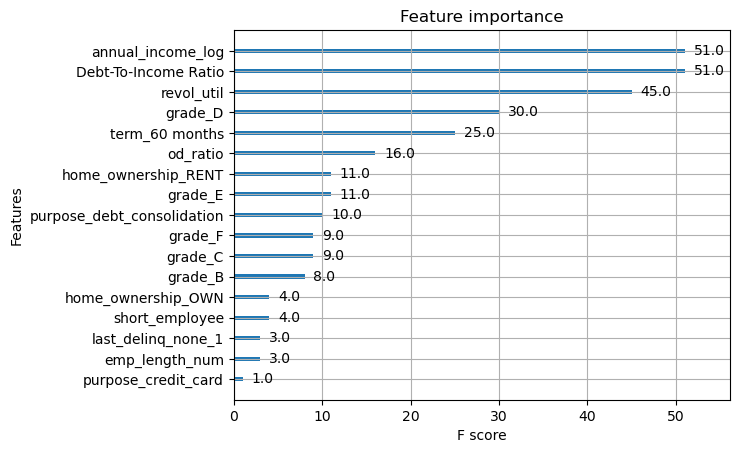

In [395]:
xgb_classifier.get_booster().feature_names =  list(X.columns)
xgb.plot_importance(xgb_classifier);

Approach 1: seperate df into two datasets by target, detect anomalies in each set

In [225]:
df_good_loan = df[df.bad_loan==0]
df_bad_loan = df[df.bad_loan==1]

In [228]:
#setting n_components=2 because of the assumption that some of the observations in the good loans are 
#miss-labeled and should have been labeled bad loans, and vice versa
gm = GaussianMixture(n_components=2, n_init=10, random_state=123)
gm.fit(df_good_loan)

GaussianMixture(n_components=2, n_init=10, random_state=123)

In [229]:
gm.weights_

array([0.06910874, 0.93089126])

In [230]:
#gm.means_

In [231]:
#gm.covariances_

In [232]:
gm.converged_, gm.n_iter_

(True, 8)

In [233]:
a_d = gm.predict(df_good_loan)
a_d.mean()

0.9308912643834684

In [247]:
df_good_loan.loc[:,'anomaly'] = (a_d+1)%2 #now 1 represents an anomaly tag
df_good_loan['annual_income_log'] = df_good_loan.annual_income.apply(lambda x: np.log(x+1))

In [248]:
pd.set_option('display.max_columns', None)
df_good_loan[df_good_loan['anomaly']==0].describe()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,anomaly,annual_income_log
count,1.367200e+04,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.0,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.000000,13672.0,13672.000000,13672.000000,13672.0,13672.000000,13672.0,13672.0,13672.0,13672.000000,13672.000000,13672.000000,13672.000000,13672.0,13672.000000
mean,7.641619e+06,75042.498098,0.107373,6.914716,16.088392,54.417848,0.001097,0.506292,0.0,0.134435,0.347791,0.287741,0.160767,0.068169,0.000805,0.000293,0.557343,0.087185,0.355471,0.009289,0.227033,0.634435,0.056978,0.0,0.018944,0.009216,0.0,0.044105,0.0,0.0,0.0,0.802297,0.197703,0.457212,0.542788,0.0,11.102514
std,1.622044e+06,46248.153883,0.309598,3.750138,7.442764,23.282014,0.128285,0.287434,0.0,0.341132,0.476287,0.452726,0.367329,0.252044,0.028354,0.017103,0.496719,0.282117,0.478673,0.095935,0.418930,0.481606,0.231809,0.0,0.136332,0.095560,0.0,0.205335,0.0,0.0,0.0,0.398282,0.398282,0.498184,0.498184,0.0,0.480475
min,5.860400e+05,8412.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000300,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,9.037533
25%,6.254814e+06,49000.000000,0.000000,4.000000,10.520000,37.600000,0.000000,0.259101,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.0,10.799596
50%,7.444636e+06,65000.000000,0.000000,7.000000,15.630000,55.600000,0.000000,0.508642,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.0,11.082158
75%,8.855503e+06,90000.000000,0.000000,11.000000,21.320000,72.300000,0.000000,0.754421,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,1.000000,1.000000,0.0,11.407576
max,1.145464e+07,1000000.000000,1.000000,11.000000,34.990000,107.700000,15.000000,0.999890,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,13.815512


In [249]:
df_good_loan[df_good_loan['anomaly']==1].describe()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,anomaly,annual_income_log
count,1.015000e+03,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.0,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.0,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.0,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.0,1015.000000
mean,7.379736e+06,82619.813793,0.089655,6.808867,15.543448,56.472861,1.325358,0.492091,0.0,0.022660,0.073892,0.116256,0.145813,0.087685,0.466010,0.087685,0.447291,0.092611,0.460099,0.0,0.067980,0.341872,0.038424,0.077833,0.006897,0.0,0.085714,0.084729,0.161576,0.073892,0.061084,0.453202,0.546798,0.476847,0.523153,1.0,11.197837
std,1.539498e+06,47613.363274,0.285828,3.683338,7.931744,26.940319,5.888805,0.292479,0.0,0.148891,0.261723,0.320690,0.353092,0.282975,0.499089,0.282975,0.497459,0.290029,0.498651,0.0,0.251836,0.474571,0.192311,0.268040,0.082799,0.0,0.280080,0.278615,0.368243,0.261723,0.239602,0.498051,0.498051,0.499710,0.499710,0.0,0.487064
min,6.948910e+05,12000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000217,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,9.392745
25%,6.162652e+06,53000.000000,0.000000,3.000000,9.265000,36.600000,0.000000,0.229017,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,10.878066
50%,7.088352e+06,71352.000000,0.000000,7.000000,15.470000,59.600000,0.000000,0.498535,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.0,11.175395
75%,8.578960e+06,100000.000000,0.000000,11.000000,21.220000,79.250000,0.000000,0.736688,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,11.512935
max,1.133533e+07,500000.000000,1.000000,11.000000,34.980000,101.700000,49.550000,0.996437,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,13.122365


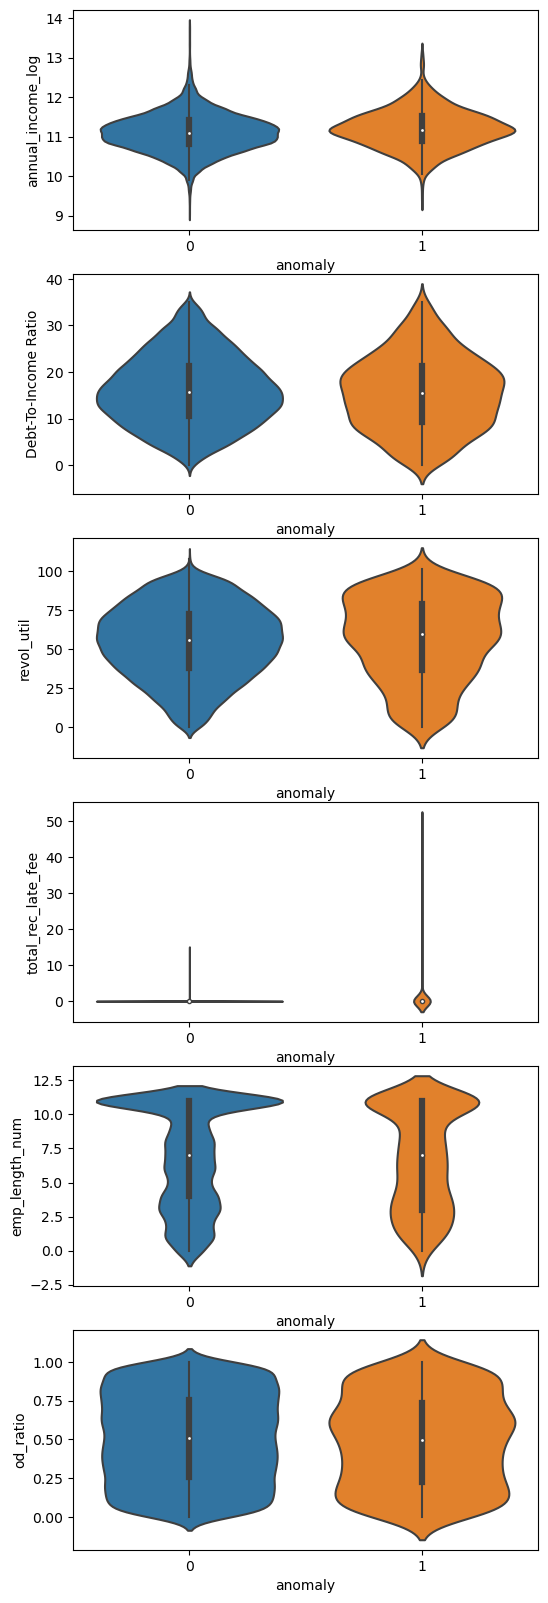

In [253]:
fig,ax = plt.subplots(6,1,figsize=(6,20))

sns.violinplot(y='annual_income_log',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[0]);

sns.violinplot(y='Debt-To-Income Ratio',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[1]);

sns.violinplot(y='revol_util',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[2]);

sns.violinplot(y='total_rec_late_fee',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[3]);

sns.violinplot(y='emp_length_num',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[4]);

sns.violinplot(y='od_ratio',
                x = 'anomaly', 
                data=df_good_loan, 
                ax=ax[5]);

In [254]:
ind = df_good_loan.index
ind

Int64Index([    0,     1,     4,     7,     8,     9,    10,    11,    13,
               14,
            ...
            18357, 18359, 18361, 18362, 18363, 18364, 18366, 18367, 18368,
            18369],
           dtype='int64', length=14687)

In [255]:
df_no_dummy = pd.read_csv('Loan_Dataset_3.csv')
df_no_dummy.iloc[8,:]

id                        9767996
grade                           G
annual_income               60000
short_employee                  0
emp_length_num                 11
home_ownership           MORTGAGE
Debt-To-Income Ratio        26.27
purpose                   medical
term                    60 months
last_delinq_none                0
revol_util                   94.1
total_rec_late_fee            0.0
od_ratio                 0.674835
bad_loan                        0
annual_income_log       11.002117
Name: 8, dtype: object

In [256]:
df_good_loan_2 = df_good_loan
df_good_loan_2

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,anomaly,annual_income_log
0,11454641,100000,1,1,26.27,43.2,0.0,0.160624,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,11.512935
1,9604874,83000,0,4,5.39,21.5,0.0,0.810777,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,11.326608
4,9795013,65000,0,11,11.26,15.2,0.0,0.166500,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,11.082158
7,7450630,96000,1,1,6.41,55.9,0.0,0.238576,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,11.472114
8,9767996,60000,0,11,26.27,94.1,0.0,0.674835,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,11.002117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18364,6615725,55000,0,8,20.07,48.9,0.0,0.648554,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,10.915107
18366,1576331,45000,0,2,23.22,46.2,0.0,0.652200,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,10.714440
18367,6645736,104000,0,5,13.27,78.5,0.0,0.482555,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,11.552156
18368,6625736,38400,0,2,12.84,47.4,0.0,0.822980,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,10.555839


In [257]:
df_no_dummy.purpose[ind]

0               credit_card
1               credit_card
4        debt_consolidation
7                     other
8                   medical
                ...        
18364    debt_consolidation
18366        major_purchase
18367    debt_consolidation
18368    debt_consolidation
18369           credit_card
Name: purpose, Length: 14687, dtype: object

In [258]:
df_good_loan_2['purpose'] = df_no_dummy.purpose[ind]
df_good_loan_2['grade'] = df_no_dummy.grade[ind]
df_good_loan_2['home_ownership'] = df_no_dummy.home_ownership[ind]
df_good_loan_2['term'] = df_no_dummy.term[ind]
df_good_loan_2['last_delinq_none'] = df_no_dummy.last_delinq_none[ind]

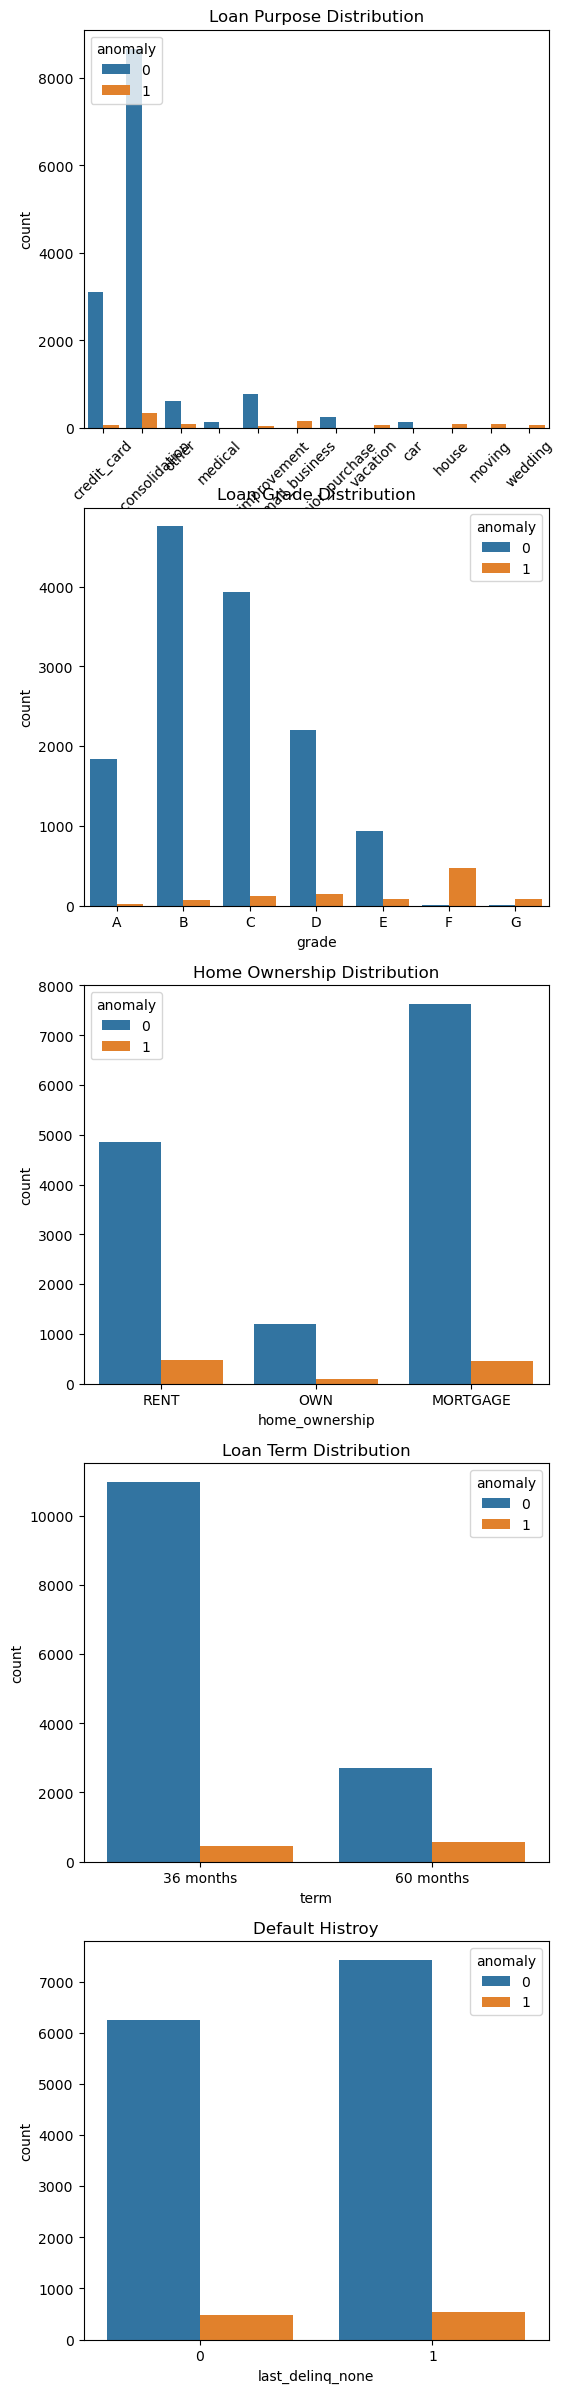

In [260]:
fig,ax = plt.subplots(5,1,figsize=(6,30))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

sns.countplot(x=df_good_loan_2.purpose, hue=df_good_loan_2.anomaly, ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Loan Purpose Distribution');

sns.countplot(x=df_good_loan_2.grade, hue=df_good_loan_2.anomaly, order=grade_order, ax=ax[1]);
ax[1].set_title('Loan Grade Distribution');

sns.countplot(x=df_good_loan_2.home_ownership, hue=df_good_loan_2.anomaly, ax=ax[2]);
ax[2].set_title('Home Ownership Distribution');

sns.countplot(x=df_good_loan_2.term, hue=df_good_loan_2.anomaly, ax=ax[3]);
ax[3].set_title('Loan Term Distribution');

sns.countplot(x=df_good_loan_2.last_delinq_none, hue=df_good_loan_2.anomaly, ax=ax[4]);
ax[4].set_title('Default Histroy');


In [64]:
#do the same thing for df_bad_loan
gm_2 = GaussianMixture(n_components=2, n_init=20)
gm_2.fit(df_bad_loan)
gm_2.weights_

array([0.81825505, 0.18174495])

In [65]:
gm_2.converged_, gm_2.n_iter_

(True, 10)

In [66]:
new_label_2 = gm_2.predict(df_bad_loan)
new_label_2

array([0, 0, 0, ..., 1, 1, 0])

In [67]:
#majority is bad loan. matches the assumption
new_label_2.mean() 

0.18191691555796904

In [68]:
df_bad_loan.loc[:,'new_label'] = new_label_2
df_bad_loan.head()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,annual_income_log,...,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,new_label
2,9684700,78000,0,11,18.45,46.3,0.0,0.035147,1,11.264477,...,0,0,0,0,0,0,1,0,1,0
3,9695736,37536,0,6,12.28,10.7,0.0,0.534887,1,10.533082,...,0,0,0,0,0,0,1,1,0,0
5,9856168,45600,1,0,1.50,14.6,0.0,0.308410,1,10.727685,...,0,0,0,0,0,0,1,1,0,0
6,9825536,45000,0,5,18.69,29.5,0.0,0.045062,1,10.714440,...,0,0,0,0,0,1,0,1,0,0
12,9808485,40800,1,1,26.21,28.4,0.0,0.524121,1,10.616462,...,0,0,0,0,0,1,0,0,1,0


,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan,annual_income_log,...,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,new_label
0,11454641,100000,1,1,26.27,43.2,0.0,0.160624,0,11.512935,...,0,0,0,0,0,1,0,0,1,0
1,9604874,83000,0,4,5.39,21.5,0.0,0.810777,0,11.326608,...,0,0,0,0,0,1,0,1,0,0
4,9795013,65000,0,11,11.26,15.2,0.0,0.166500,0,11.082158,...,0,0,0,0,0,1,0,1,0,0
7,7450630,96000,1,1,6.41,55.9,0.0,0.238576,0,11.472114,...,0,1,0,0,0,1,0,1,0,0
8,9767996,60000,0,11,26.27,94.1,0.0,0.674835,0,11.002117,...,0,0,0,0,0,0,1,1,0,0


In [73]:
X = df.drop(columns=['id', 'annual_income','bad_loan','grade_A',
                     'home_ownership_MORTGAGE','purpose_car','term_36 months',
                     'last_delinq_none_0'])

y = df['new_label'].astype(int)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [74]:
X_train

array([[ 2.78251958, -1.54570536,  1.08995282, ..., -0.06613603,
        -0.58185516,  0.90625127],
       [-0.35938651, -1.01560908,  0.56622987, ..., -0.06613603,
        -0.58185516,  0.90625127],
       [-0.35938651,  0.04458349, -0.63385889, ..., -0.06613603,
        -0.58185516,  0.90625127],
       ...,
       [-0.35938651,  1.10477606,  0.44780006, ..., -0.06613603,
        -0.58185516, -1.10344673],
       [-0.35938651, -0.48551279, -0.87203441, ..., -0.06613603,
        -0.58185516,  0.90625127],
       [-0.35938651,  1.10477606, -1.67604124, ..., -0.06613603,
        -0.58185516,  0.90625127]])

In [75]:
def get_metrics(target_test, target_score):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    print(f'AUC is {pr_auc:.2f}')
    return precision, recall, pr_auc

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

### K-Means

#### Logistic Regression

Attempt 1: classifier is trained on cluster assignments only

In [109]:
lg_clf = LogisticRegression(class_weight='balanced', 
                                   C=10,
                                   max_iter=10000,
                                   random_state = 123)

In [94]:
lg_clf = LogisticRegression(class_weight='balanced', 
                                   C=10,
                                   max_iter=10000,
                                   random_state = 123)

pipeline = Pipeline([
    #The output of this step is the cluster assignments for each data point in the input dataset
    ('kmeans', KMeans()),
    #The logistic regression model is trained on the cluster assignments 
    #(features) and the corresponding labels (target)
    ('log_reg', lg_clf)
])

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv = 5, verbose = 0, n_jobs=-1)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'kmeans__n_clusters': 2}

In [95]:
grid_clf.best_estimator_

Pipeline(steps=[('kmeans', KMeans(n_clusters=2)),
                ('log_reg',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=10000, random_state=123))])

In [96]:
best_pl = grid_clf.best_estimator_
best_pl.fit(X_train, y_train)
y_pred = best_pl.predict(X_test)
y_score = best_pl.predict_proba(X_test)[:,1]

In [97]:
get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2175,762
Actual Positive,433,304


In [98]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.28


Performance got much worse

Attempt 2: what if the cluster assignment becomes one of the features

In [104]:
kmeans_model = best_pl['kmeans']
train_cluster_assignments = kmeans_model.fit_predict(X_train).reshape(-1,1)
test_cluster_assignments = kmeans_model.predict(X_test).reshape(-1,1)

In [105]:
X_train_km = np.hstack((X_train, train_cluster_assignments))
X_train_km.shape, X_train.shape

((14696, 29), (14696, 28))

In [106]:
X_test_km = np.hstack((X_test, test_cluster_assignments))
X_test_km.shape, X_test.shape

((3674, 29), (3674, 28))

In [111]:
lg_clf.fit(X_train_km, y_train)
y_pred = lg_clf.predict(X_test_km)
y_score = lg_clf.predict_proba(X_test_km)[:,1]

In [112]:
get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1922,1015
Actual Positive,244,493


In [114]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.39


Same performance as the log reg in Predict_bad_loan.ipynb

#### XGBoost

In [117]:
param_grid = [
    {'n_estimators': [94, 95, 96],
     'max_depth': [1,2, 3, 4],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='logloss',
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True,
                          n_jobs=-1)

grid_search.fit(X_train_km, y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 95}

In [118]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train_km, y_train)
y_pred = xgb_classifier.predict(X_test_km)
y_score = xgb_classifier.predict_proba(X_test_km)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2933,4
Actual Positive,725,12


In [119]:
xgb_precision, xgb_recall, xgb_pr_auc = get_metrics(y_test, y_score)

AUC is 0.38


In [134]:
features = list(X.columns)
features.append('cluster')

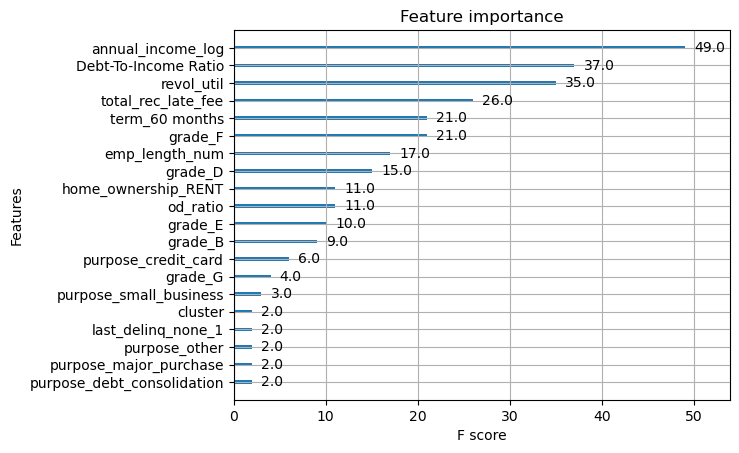

In [136]:
xgb_classifier.get_booster().feature_names =  features
xgb.plot_importance(xgb_classifier);

the importance of the new feature, 'cluster', is low according to xgb's importance chart above.
see if there is a pattern about the target variable in these clusters

In [157]:
kmeans_model

KMeans(n_clusters=2)

In [156]:
num_cluster = 2

for cluster in list(range(num_cluster)):
    default_p = (y_train[train_cluster_assignments.ravel()==cluster]).mean()
    print(f'In Cluster {cluster}, the percentage of defaulted loan is {default_p*100: .0f}%.')

In Cluster 0, the percentage of defaulted loan is  20%.
In Cluster 1, the percentage of defaulted loan is  20%.


cry. both clusters contain 20% bad loans. it is the same pattern as that in the original dataset. conclusion: kmeans cluster as an additional feature does not help improve classifers' performances. both of log reg and xgb classifiers' AUC's verify such.

### DBSCAN

In [160]:
dbscan = DBSCAN(eps = 6, min_samples = 3) #need to find the optimal hyperparameters
dbscan.fit(X_train)

DBSCAN(eps=6, min_samples=3)

In [161]:
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [162]:
print(f'In the X_train dataset, there are {len(set(dbscan.labels_))} clusters or unique labels, and \
{(dbscan.labels_ ==  -1).sum()} of the data points are anomalies.')

In the X_train dataset, there are 13 clusters or unique labels, and 22 of the data points are anomalies.


In [163]:
len(dbscan.labels_), X_train.shape[0]

(14696, 14696)

In [164]:
X_train_dbscan_label = dbscan.labels_.reshape(-1, 1)

DBSCAN class does not have a predict() method. Use KNN to predict the cluster for X_test based on maximum distance

In [165]:
#the n_neighbors parameter determines the number of neighbors that will be considered when making predictions
knn = KNeighborsClassifier(n_neighbors = 50)

#core instances are in the components_ instance variable
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [167]:
#1. find the nearest neighbor of the data points X_test using the k-nearest neighbors algorithm
dist, pred_idx = knn.kneighbors(X_test, n_neighbors = 1)

#2. identify the cluster labels of the nearest neighbor
label_pred = dbscan.labels_[dbscan.core_sample_indices_][pred_idx]

#3. to label anomalies, identify points that are not close enough  (> 6)
#to any cluster and consider them outliers.
label_pred[dist > 6] = -1

label_pred = label_pred.ravel()

In [168]:
set(label_pred), len(label_pred), X_test.shape[0]

({-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11}, 3674, 3674)

In [169]:
X_test_dbscan_label = label_pred.reshape(-1, 1)

#### Logistic Regression

Attempt 1: classifier is trained on DBSCAN labels only

In [172]:
X_train_dbscan_label.shape

(14696, 1)

In [173]:
lg_clf.fit(X_train_dbscan_label, y_train)
y_pred = lg_clf.predict(X_test_dbscan_label)
y_score = lg_clf.predict_proba(X_test_dbscan_label)[:,1]
get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,140,2797
Actual Positive,46,691


In [174]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.21


Attempt 2: DBSCAN label becomes one of the features

In [179]:
X_train_dbscan = np.hstack((X_train, dbscan.labels_.reshape(-1,1)))
X_train_dbscan.shape, X_train.shape

((14696, 29), (14696, 28))

In [180]:
X_test_dbscan = np.hstack((X_test, label_pred.reshape(-1,1)))
X_test_dbscan.shape, X_test.shape

((3674, 29), (3674, 28))

In [181]:
lg_clf.fit(X_train_dbscan, y_train)
y_pred = lg_clf.predict(X_test_dbscan)
y_score = lg_clf.predict_proba(X_test_dbscan)[:,1]
get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1921,1016
Actual Positive,243,494


In [182]:
lg_precision, lg_recall, lg_pr_auc = get_metrics(y_test, y_score)

AUC is 0.38


0.01 worse in performance compared with the log reg in Predict_bad_loan.ipynb

#### XGBoost

In [184]:
xgb_classifier.fit(X_train_dbscan, y_train)
y_pred = xgb_classifier.predict(X_test_dbscan)
y_score = xgb_classifier.predict_proba(X_test_dbscan)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2933,4
Actual Positive,725,12


In [185]:
xgb_precision, xgb_recall, xgb_pr_auc = get_metrics(y_test, y_score)

AUC is 0.38


In [186]:
features = list(X.columns)
features.append('dbscan_label')

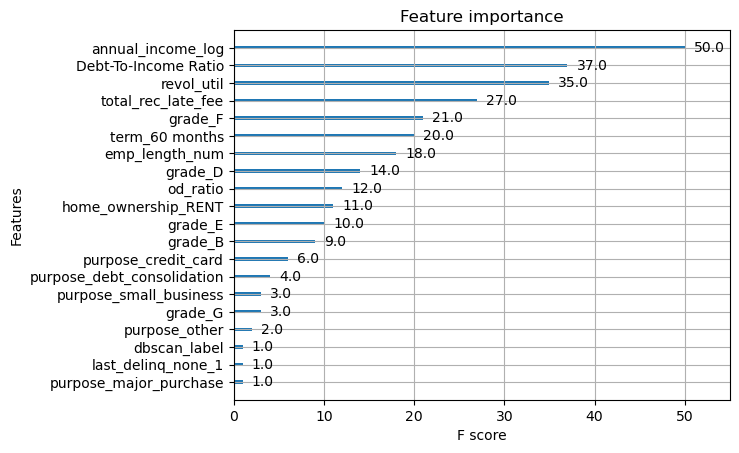

In [187]:
xgb_classifier.get_booster().feature_names =  features
xgb.plot_importance(xgb_classifier);

conclusion: neither DBSCAN label as a lone feature or an additional feature helps improve performance. perhaps tuning the hyperparameters more might help. ?

### Agglomerative Hierarchical Clustering

In [45]:
connect = kneighbors_graph(X_train, n_neighbors=5, include_self=False)
connectivity = cluster.AgglomerativeClustering(n_clusters=12, affinity='euclidean', 
                                              linkage='complete', connectivity=connect).fit_predict(X_train)

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:550: UserWarning: the number of connected components of the connectivity matrix is 16 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


In [46]:
print(*["Cluster "+str(i)+": "+ str(sum(connectivity==i)) for i in range(12)], sep='\n')

Cluster 0: 92
Cluster 1: 3
Cluster 2: 2
Cluster 3: 128
Cluster 4: 14145
Cluster 5: 76
Cluster 6: 65
Cluster 7: 1
Cluster 8: 72
Cluster 9: 2
Cluster 10: 108
Cluster 11: 2


In [66]:
#see if there is a pattern about the target variable in these clusters
num_cluster = np.unique(connectivity)

for cluster in num_cluster:
    default_p = (y_train[connectivity==cluster]).mean()
    print(f'In Cluster {cluster}, the percentage of defaulted loan is {default_p*100: .0f}%.')

In Cluster 0, the percentage of defaulted loan is  26%.
In Cluster 1, the percentage of defaulted loan is  67%.
In Cluster 2, the percentage of defaulted loan is  100%.
In Cluster 3, the percentage of defaulted loan is  22%.
In Cluster 4, the percentage of defaulted loan is  20%.
In Cluster 5, the percentage of defaulted loan is  24%.
In Cluster 6, the percentage of defaulted loan is  25%.
In Cluster 7, the percentage of defaulted loan is  100%.
In Cluster 8, the percentage of defaulted loan is  14%.
In Cluster 9, the percentage of defaulted loan is  100%.
In Cluster 10, the percentage of defaulted loan is  41%.
In Cluster 11, the percentage of defaulted loan is  50%.


Most of the major clusters, such as 0, 3, 4, 5, 6, have around 20% bad loans, just like the full dataset. Seems like the clustering action does not classify loan applicants in a way that can help with default prediction.